In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [3]:
df = pd.read_csv("data/riceClassification.csv")
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [4]:
df.isna().sum()

id                 0
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Perimeter          0
Roundness          0
AspectRation       0
Class              0
dtype: int64

In [5]:
df.drop(columns=['id'], inplace=True)
df.shape

(18185, 11)

<Axes: xlabel='Class'>

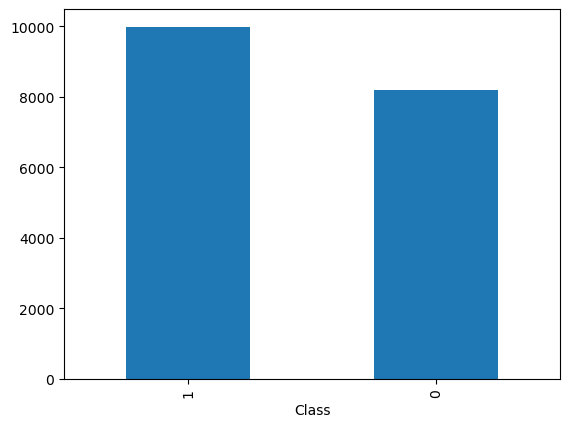

In [6]:
df.Class.value_counts().plot(kind='bar')

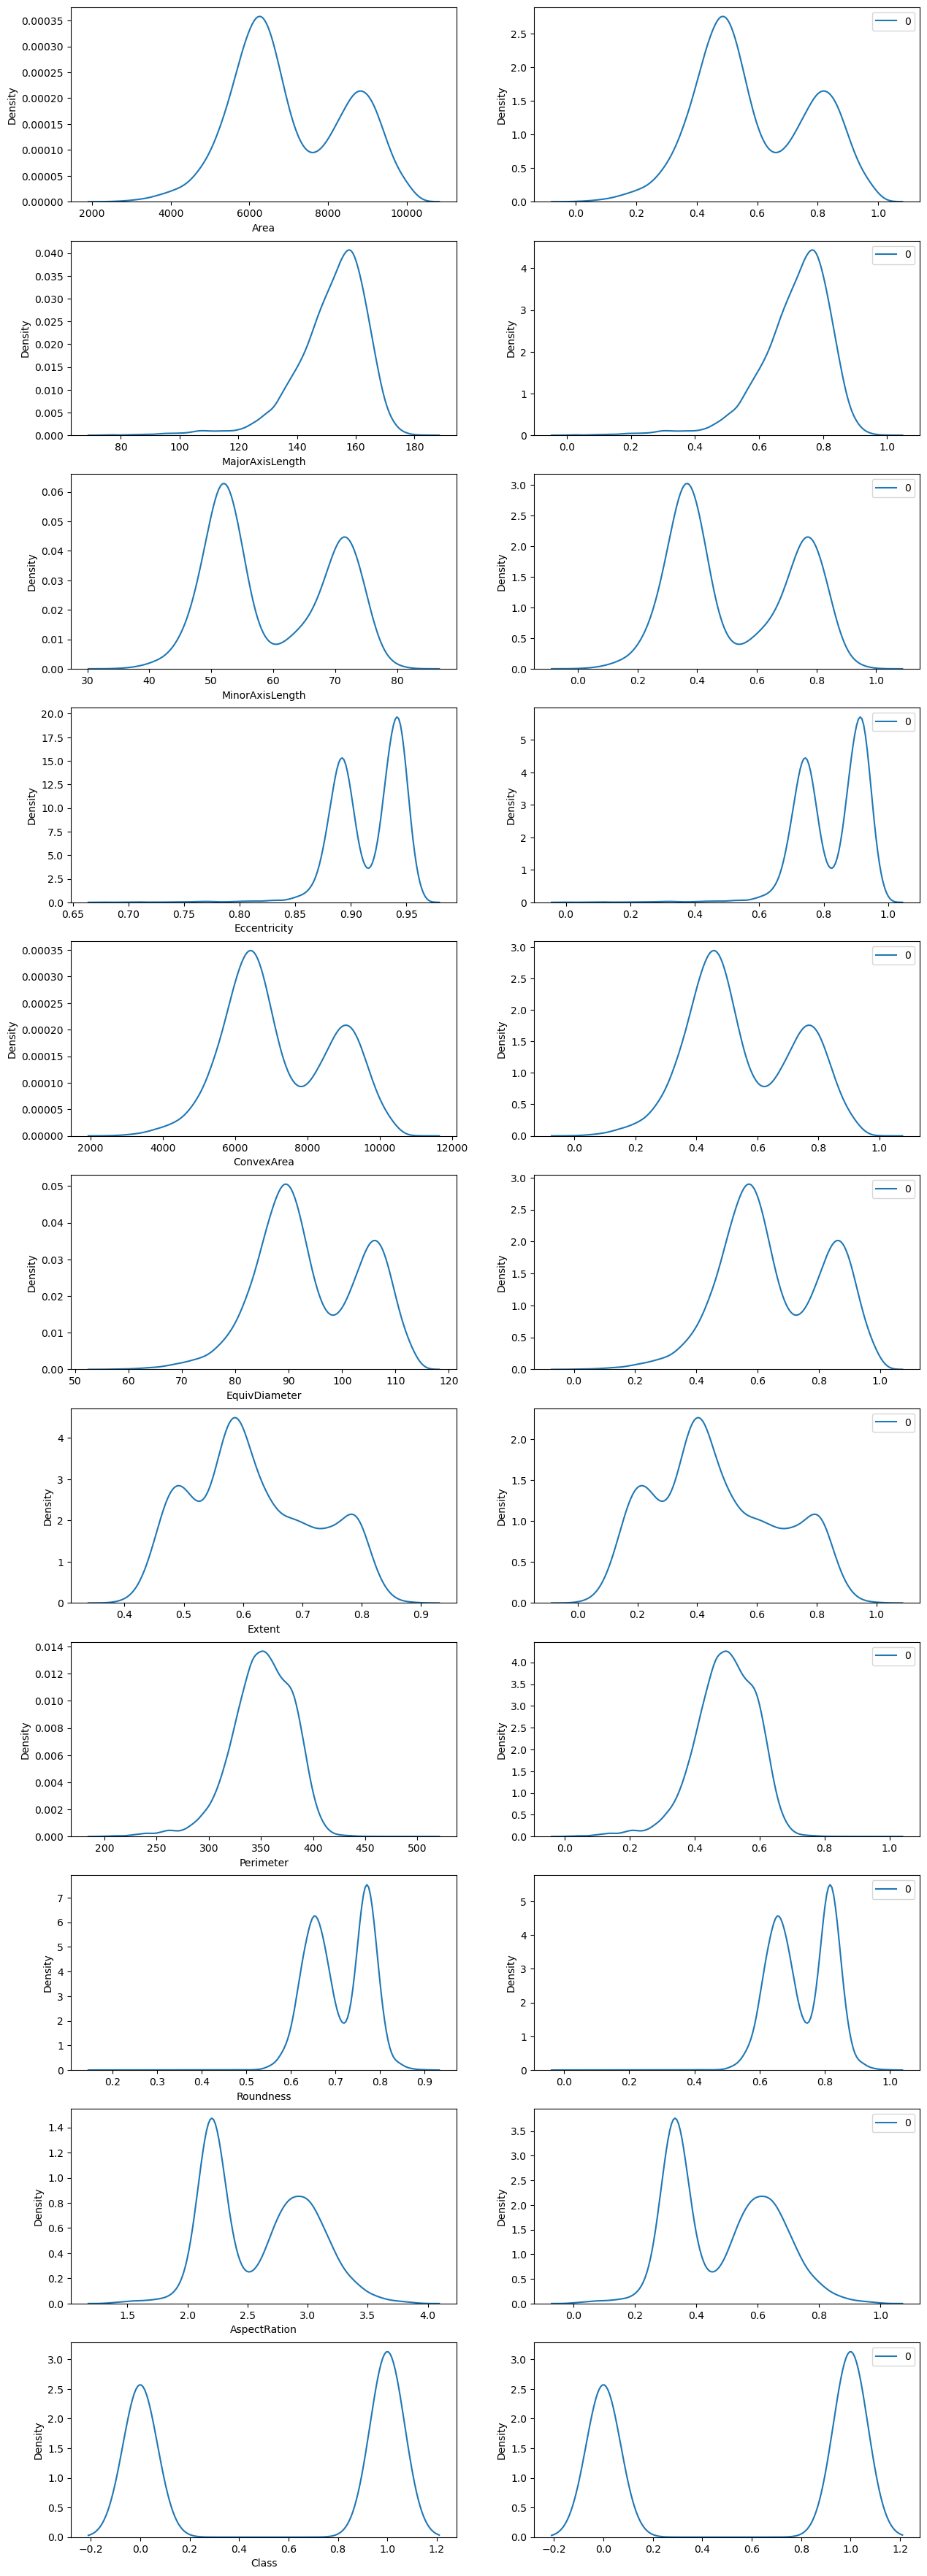

In [7]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

fig, ax = plt.subplots(len(df.columns), 2, figsize=(15, 45))

for i, col in enumerate(df.columns):
    sns.kdeplot(df[col], ax=ax[i, 0])
    # ax[i, 0].set_title(col)
    sns.kdeplot(MinMaxScaler().fit_transform(df[[col]]), ax=ax[i, 1])
    # ax[i, 1].set_title(col + ' (Normalised)')


plt.show()

In [8]:
scaler = MinMaxScaler()

# scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
scaled_df = scaler.fit_transform(df)
scaled_df[:5].shape

(5, 11)

In [9]:
X, y = scaled_df[:, :-1], scaled_df[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, train_size=0.5, random_state=42)

X.shape, X_train.shape, X_test.shape, X_val.shape

((18185, 10), (14548, 10), (1818, 10), (1819, 10))

In [10]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [11]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [22]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)


In [23]:
for x, y in train_dataloader:
    print(x)
    print('='*10)
    print(y)
    break

tensor([[0.6778, 0.7026, 0.6603, 0.7645, 0.6262, 0.7421, 0.7419, 0.5020, 0.8267,
         0.3601],
        [0.6744, 0.5895, 0.8007, 0.5970, 0.6245, 0.7392, 0.8497, 0.4737, 0.8781,
         0.2112],
        [0.4300, 0.6596, 0.3636, 0.8895, 0.4028, 0.5140, 0.1902, 0.4248, 0.6856,
         0.5700],
        [0.5038, 0.7738, 0.3842, 0.9170, 0.4791, 0.5853, 0.3987, 0.5071, 0.6343,
         0.6417],
        [0.7934, 0.7909, 0.7166, 0.7802, 0.7351, 0.8389, 0.8300, 0.5733, 0.8128,
         0.3797],
        [0.2562, 0.6204, 0.1432, 0.9651, 0.2591, 0.3306, 0.6552, 0.3889, 0.5246,
         0.8126],
        [0.6268, 0.6421, 0.6575, 0.7314, 0.5945, 0.6977, 0.6276, 0.4811, 0.8110,
         0.3228],
        [0.6289, 0.7097, 0.6006, 0.7992, 0.5958, 0.6995, 0.4900, 0.5110, 0.7589,
         0.4054],
        [0.7063, 0.7255, 0.6709, 0.7709, 0.6542, 0.7664, 0.6432, 0.5256, 0.8126,
         0.3679],
        [0.4122, 0.6925, 0.3011, 0.9253, 0.3821, 0.4962, 0.1669, 0.4274, 0.6595,
         0.6666],
        [0

In [24]:
HIDDEN_NEURONS = 10

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.output_layer = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)

        return x

model = MyModel().to(device)

In [25]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [40]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [41]:
total_train_loss_plot = []
total_val_loss_plot = []

total_train_acc_plot = []
total_val_acc_plot = []

epochs = 20
for epoch in range(epochs):
    total_train_loss = total_train_acc = total_val_loss = total_val_acc = 0
    for data in train_dataloader:
        inputs, labels = data
        pred = model(inputs).squeeze(1)

        batch_loss = criterion(pred, labels)
        total_train_loss += batch_loss.item()

        batch_acc = ((pred).round() == labels).sum().item()
        total_train_acc += batch_acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            pred = model(inputs).squeeze(1)

            batch_loss = criterion(pred, labels)
            total_val_loss += batch_loss.item()

            batch_acc = (pred.round() == labels).sum().item()
            total_val_acc += batch_acc
    
    total_train_loss_plot.append(round(total_train_loss / 1000, 4))
    total_val_loss_plot.append(round(total_val_loss / 1000, 4))

    total_train_acc_plot.append(round(total_train_acc / training_data.__len__() * 100, 4))
    total_val_acc_plot.append(round(total_val_acc / validation_data.__len__() * 100, 4))

    print(f'''Epoch: {epoch + 1}, Training Loss: {total_train_loss_plot[-1]}, Training Accuracy: {total_train_acc_plot[-1]} 
                Validation Loss: {total_val_loss_plot[-1]}, Validation Accuracy: {total_val_acc_plot[-1]}''')
    print('='*50)

Epoch: 1, Training Loss: 0.018, Training Accuracy: 98.6596 
                Validation Loss: 0.0029, Validation Accuracy: 98.1858
Epoch: 2, Training Loss: 0.018, Training Accuracy: 98.694 
                Validation Loss: 0.0029, Validation Accuracy: 98.2408
Epoch: 3, Training Loss: 0.018, Training Accuracy: 98.6871 
                Validation Loss: 0.0029, Validation Accuracy: 98.1858
Epoch: 4, Training Loss: 0.018, Training Accuracy: 98.6596 
                Validation Loss: 0.003, Validation Accuracy: 98.2408
Epoch: 5, Training Loss: 0.0179, Training Accuracy: 98.6871 
                Validation Loss: 0.0029, Validation Accuracy: 98.2408
Epoch: 6, Training Loss: 0.018, Training Accuracy: 98.7077 
                Validation Loss: 0.0029, Validation Accuracy: 98.1858
Epoch: 7, Training Loss: 0.0179, Training Accuracy: 98.6734 
                Validation Loss: 0.0029, Validation Accuracy: 98.2408
Epoch: 8, Training Loss: 0.0181, Training Accuracy: 98.6596 
                Validation Lo

In [42]:
with torch.no_grad():
    total_test_loss = total_test_acc = 0

    for data in test_dataloader:
        inputs, labels = data
        pred = model(inputs).squeeze(1)

        batch_loss = criterion(pred, labels)
        total_test_loss += batch_loss.item()

        batch_acc = (pred.round() == labels).sum().item()
        total_test_acc += batch_acc

print(f"Testing Accuracy: {round(total_test_acc / testing_data.__len__() * 100, 4)}")

Testing Accuracy: 99.1199


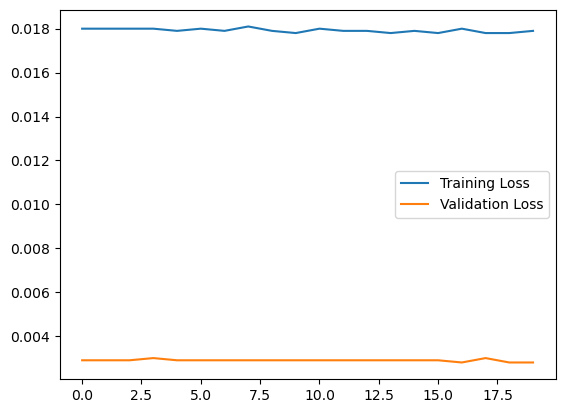

In [43]:
plt.plot(total_train_loss_plot, label='Training Loss')
plt.plot(total_val_loss_plot, label='Validation Loss')
plt.legend()
plt.show()

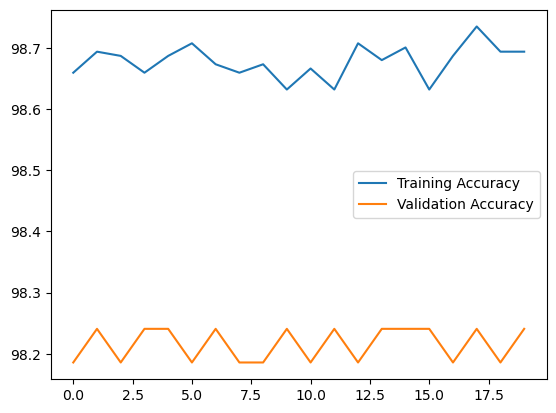

In [44]:
plt.plot(total_train_acc_plot, label='Training Accuracy')
plt.plot(total_val_acc_plot, label='Validation Accuracy')
plt.legend()
plt.show()